In [917]:
import os
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Union


if not os.path.exists('../models'):
    os.makedirs('../models')
if not os.path.exists('../plots'):
    os.makedirs('../plots')

In [918]:
def main(args):
    """Main Function"""

    data = get_data(args['data_path'])  # Loading the data
    print("Data loaded.")
    
    # Preprocess the data
    data = preprocess_data(data)
    print("Data preprocessed.")
    
    model = DLModel()  # Initializing the model
    model = train_model(data, model)  # Training the model
    model.save(args['model_path'])  # Saving the model
    
    plot(model, args['plot_path'])  # Plotting the model
    
    # Printing the model parameters
    print_model_params(model)

    # Calculate the normalised squared error
    calculate_loss(model, data)

In [919]:
def get_data(data_path) -> Union[pd.DataFrame, np.ndarray]:
    """
    Loads the data from the given path and returns a pandas dataframe.

    Args:
        path (str): Path to the data file.

    Returns:
        pd.DataFrame, np.ndarray: Data Structure containing the loaded data
    """
    data = pd.read_csv(data_path)  # Load data from CSV file
    return data

In [920]:
def preprocess_data(data: Union[pd.DataFrame, np.ndarray]) -> Union[pd.DataFrame, np.ndarray]:
    """Preprocesses the dataframe by
    (i)   removing the unnecessary columns,
    (ii)  loading date in proper format DD-MM-YYYY,
    (iii) removing the rows with missing values,
    (iv)  anything else you feel is required for training your model.

    Args:
        data (pd.DataFrame, nd.ndarray): Pandas dataframe containing the loaded data

    Returns:
        pd.DataFrame, np.ndarray: Datastructure containing the cleaned data.
    """
    for date in data['Date']:
        try:
            date_string = date
            month, day_range, year = date_string.split(' ')
            start_day = int(day_range.split('-')[0])
            new_date_string = f'{start_day:02d} {month} {year}'
            parsed_date = pd.to_datetime(new_date_string, format='%d %b %Y')
            new_date = parsed_date
            timestamp = pd.to_datetime(new_date)
            formatted_date = timestamp.strftime('%d/%m/%Y')
            data['Date'].replace({date: formatted_date}, inplace=True)
        except:
            pass
    # (i) Removing unnecessary columns
    keep_columns = ['Innings','Date','Over','Runs','Total.Runs','Innings.Total.Runs','Runs.Remaining','Total.Overs','Wickets.in.Hand']
    data = data[keep_columns]
    overs_completed = data['Over'].values
    total_overs = data['Total.Overs'].values
    data['Overs.Remaining'] = total_overs - overs_completed
    
    # (ii) Loading date in proper format DD-MM-YYYY
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
   
    
    # (iii) Removing rows with missing values
    data = data.dropna()
    
    # (iv) Any other preprocessing steps you require
    
    return data


In [921]:
class DLModel:
    """
        Model Class to approximate the Z function as defined in the assignment.
    """

    def __init__(self):
        """Initialize the model."""
        self.Z0 = [None] * 10
        self.L = None
    
    def get_predictions(self, X, Z_0=None, w=10, L=None) -> np.ndarray:
        """Get the predictions for the given X values.

        Args:
            X (np.array): Array of overs remaining values.
            Z_0 (float, optional): Z_0 as defined in the assignment.
                                   Defaults to None.
            w (int, optional): Wickets in hand.
                               Defaults to 10.
            L (float, optional): L as defined in the assignment.
                                 Defaults to None.

        Returns:
            np.array: Predicted score possible
        """
        if Z_0 is None:
            Z_0 = self.Z0[w - 1]
        if L is None:
            L = self.L
        predictions = Z_0 * (1 - np.exp(-L * X / Z_0))
        return predictions


    def calculate_loss(self, Params, X, Y, w=10) -> float:
        """ Calculate the loss for the given parameters and datapoints.
        Args:
            Params (list): List of parameters to be optimized.
            X (np.array): Array of overs remaining values.
            Y (np.array): Array of actual average score values.
            w (int, optional): Wickets in hand.
                               Defaults to 10.

        Returns:
            float: Mean Squared Error Loss for the model parameters 
                   over the given datapoints.
        """
        Z_0 = Params[0]
        L = Params[1]
        predictions = self.get_predictions(X, Z_0, w, L)
        loss = np.mean((predictions - Y)**2)
        return loss

    
    def save(self, path):
        """Save the model to the given path.

        Args:
            path (str): Location to save the model.
        """
        with open(path, 'wb') as f:
            pickle.dump((self.L, self.Z0), f)
    
    def load(self, path):
        """Load the model from the given path.

        Args:
            path (str): Location to load the model.
        """
        with open(path, 'rb') as f:
            (self.L, self.Z0) = pickle.load(f)


In [922]:
def train_model(data: Union[pd.DataFrame, np.ndarray], model: DLModel) -> DLModel:
    """Trains the model

    Args:
        data (pd.DataFrame, np.ndarray): Datastructure containing the cleaned data
        model (DLModel): Model to be trained
    """
    
    initial_params = [300, 0.02]  # Initial parameter values
    # Perform model training
    for w in range(1, 11):  # Iterate over wickets from 1 to 10
        fd=data[(data['Innings']==1) & (data['Wickets.in.Hand']==w)]
        X = fd['Overs.Remaining'].values  # Overs remaining values from data
        Y = fd['Runs.Remaining'].values    # Actual average score values from data
        optimized_params = sp.optimize.minimize(
            model.calculate_loss, initial_params, args=(X, Y, w), method='L-BFGS-B'
        ).x

        # Update the model with the optimized parameters for the specific wicket (w)
        model.Z0[w - 1] = optimized_params[0]
        model.L = optimized_params[1]

    return model


In [923]:
def plot(model: DLModel, plot_path: str) -> None:
    """ Plots the model predictions against the number of overs
        remaining according to wickets in hand.

    Args:
        model (DLModel): Trained model
        plot_path (str): Path to save the plot
    """
    wickets = np.arange(1, 11)  # Wickets in hand values from 1 to 10
    overs_values = np.linspace(0, 50, num=100)  # Overs remaining values
    line = []
    plt.figure(figsize=(10, 7))
    #For Center Line
    for i in range(len(overs_values)):
        line.append(2*i)
    plt.plot(overs_values, line, color='blue')

    for w in wickets:
        predictions = model.get_predictions(overs_values, w=w)
        plt.plot(overs_values, predictions, label=f'w = {w}')

    plt.xlabel('Overs to Go')
    plt.ylabel('Predicted Run Production')
    plt.title('Run Production Functions for Different Wickets in Hand')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)
    plt.show()


In [924]:
def print_model_params(model: DLModel) -> List[float]:
    '''
    Prints the 11 (Z_0(1), ..., Z_0(10), L) model parameters

    Args:
        model (DLModel): Trained model
    
    Returns:
        array: 11 model parameters (Z_0(1), ..., Z_0(10), L)

    '''
    model_params = model.Z0 + [model.L]
    for i, param in enumerate(model.Z0):
        print(f'Parameter {i + 1}: {param}')
    print(f'Parameter L:',model.L)
    
    return model_params

In [925]:
def calculate_loss(model: DLModel, data: Union[pd.DataFrame, np.ndarray]) -> float:
    '''
    Calculates the normalised squared error loss for the given model and data

    Args:
        model (DLModel): Trained model
        data (pd.DataFrame or np.ndarray): Data to calculate the loss on
    
    Returns:
        float: Normalised squared error loss for the given model and data
    '''
    X = data['Overs.Remaining'].values  # Overs remaining values from data
    Y = data['Runs.Remaining'].values    # Actual average score values from data
    
    # Initialize the loss
    loss = 0.0
    
    for w in range(1, 11):  # Iterate over wickets from 1 to 10
        # Get the predictions using the model for the current wicket (w)
        predictions = model.get_predictions(X, w=w)
        
        # Calculate squared errors
        squared_errors = (predictions - Y)**2
        
        # Accumulate the squared errors for the current wicket (w)
        loss += np.sum(squared_errors)
    
    # Normalize the loss by dividing by the total number of data points, wickets, and overs
    normalized_loss = loss / (len(data) * 10 * len(X))
    print(normalized_loss)
    return normalized_loss


Data loaded.
Data preprocessed.


/var/folders/kx/whksmmfd0sz7xt3kxkgmwk6w0000gn/T/ipykernel_17279/293357401.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Overs.Remaining'] = total_overs - overs_completed
/var/folders/kx/whksmmfd0sz7xt3kxkgmwk6w0000gn/T/ipykernel_17279/293357401.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')


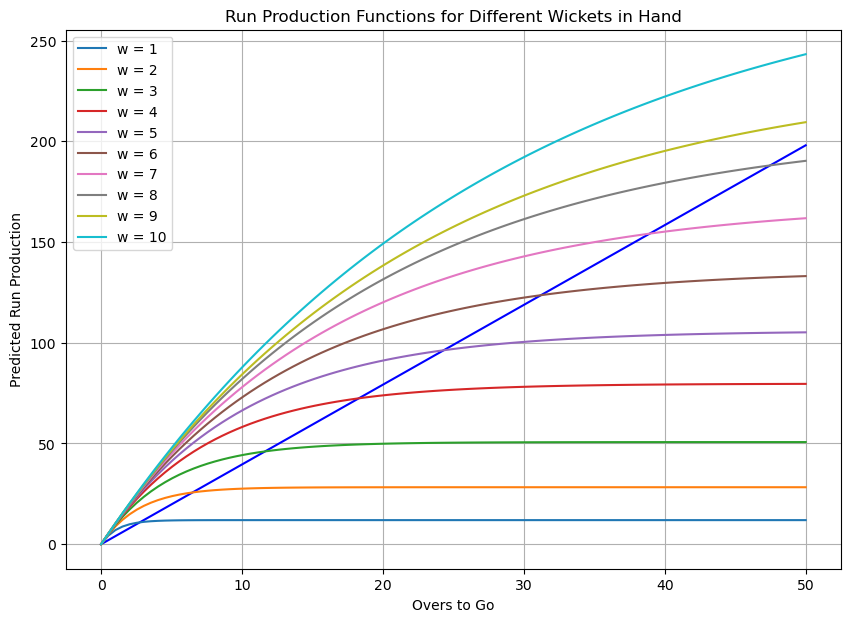

Parameter 1: 11.95937554313004
Parameter 2: 28.28896970954003
Parameter 3: 50.70279460648361
Parameter 4: 79.70076188688158
Parameter 5: 105.94215602199687
Parameter 6: 136.02249837466613
Parameter 7: 169.6483768624815
Parameter 8: 206.92440617209184
Parameter 9: 235.0089761138293
Parameter 10: 292.25551052336453
Parameter L: 10.433050730040572
0.05570773570413238


In [926]:
if __name__ == '__main__':
    args = {
        "data_path": "../data/04_cricket_1999to2011.csv",
        "model_path": "../models/model.pkl",  # ensure that the path exists
        "plot_path": "../plots/plot.png",  # ensure that the path exists
    }
    main(args)
